# Infino

This example shows how one can track the following while calling OpenAI and ChatOpenAI models via `LangChain` and [Infino](https://github.com/infinohq/infino):

* prompt input,
* response from `ChatGPT` or any other `LangChain` model,
* latency,
* errors,
* number of tokens consumed

## Initializing

In [22]:
# Install necessary dependencies.
!pip install infinopy
!pip install matplotlib

In [23]:
import datetime as dt
import json
from langchain.llms import OpenAI
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import time
import sys

from infinopy import InfinoClient
from langchain.callbacks import InfinoCallbackHandler

## Start Infino server, initialize the Infino client

In [24]:
# Start server using the Infino docker image.
!docker run --rm --detach --name infino-example -p 3000:3000 infinohq/infino:latest

# Create Infino client.
client = InfinoClient()

bafc657bba443ffbc1286d8b59e11b2b3ad1fb2b1c9c6675eda93f1e54ea3391


## Read the questions dataset

In [25]:
# These are a subset of questions from Stanford's QA dataset -
# https://rajpurkar.github.io/SQuAD-explorer/
data = """In what country is Normandy located?
When were the Normans in Normandy?
From which countries did the Norse originate?
Who was the Norse leader?
What century did the Normans first gain their separate identity?
Who gave their name to Normandy in the 1000's and 1100's
What is France a region of?
Who did King Charles III swear fealty to?
When did the Frankish identity emerge?
Who was the duke in the battle of Hastings?
Who ruled the duchy of Normandy
What religion were the Normans
What type of major impact did the Norman dynasty have on modern Europe?
Who was famed for their Christian spirit?
Who assimilted the Roman language?
Who ruled the country of Normandy?
What principality did William the conquerer found?
What is the original meaning of the word Norman?
When was the Latin version of the word Norman first recorded?
What name comes from the English words Normans/Normanz?"""

questions = data.split("\n")

## Example 1: LangChain OpenAI Q&A; Publish metrics and logs to Infino

In [26]:
# Set your key here.
# os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

# Create callback handler. This logs latency, errors, token usage, prompts as well as prompt responses to Infino.
handler = InfinoCallbackHandler(
    model_id="test_openai", model_version="0.1", verbose=False
)

# Create LLM.
llm = OpenAI(temperature=0.1)

# Number of questions to ask the OpenAI model. We limit to a short number here to save $$ while running this demo.
num_questions = 10

questions = questions[0:num_questions]
for question in questions:
    print(question)

    # We send the question to OpenAI API, with Infino callback.
    llm_result = llm.generate([question], callbacks=[handler])
    print(llm_result)

In what country is Normandy located?
generations=[[Generation(text='\n\nNormandy is located in France.', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'completion_tokens': 9, 'total_tokens': 16, 'prompt_tokens': 7}, 'model_name': 'text-davinci-003'} run=[RunInfo(run_id=UUID('e45e9348-d98e-4540-ad8e-f90ffc003707'))]
When were the Normans in Normandy?
generations=[[Generation(text='\n\nThe Normans first settled in Normandy in the early 10th century.', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'completion_tokens': 16, 'total_tokens': 24, 'prompt_tokens': 8}, 'model_name': 'text-davinci-003'} run=[RunInfo(run_id=UUID('a8e99071-c2b9-4f63-bd34-f735040ac856'))]
From which countries did the Norse originate?
generations=[[Generation(text='\n\nThe Norse originated from Scandinavia, which includes the modern-day countries of Norway, Sweden, and Denmark.', generation_info={'finish_reason': 'stop', 'logpro

## Create Metric Charts

We now use matplotlib to create graphs of latency, errors and tokens consumed.

In [27]:
# Helper function to create a graph using matplotlib.
def plot(data, title):
    data = json.loads(data)

    # Extract x and y values from the data
    timestamps = [item["time"] for item in data]
    dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]
    y = [item["value"] for item in data]

    plt.rcParams["figure.figsize"] = [6, 4]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)

    # Create the plot
    plt.plot(dates, y)

    # Set labels and title
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)

    plt.show()



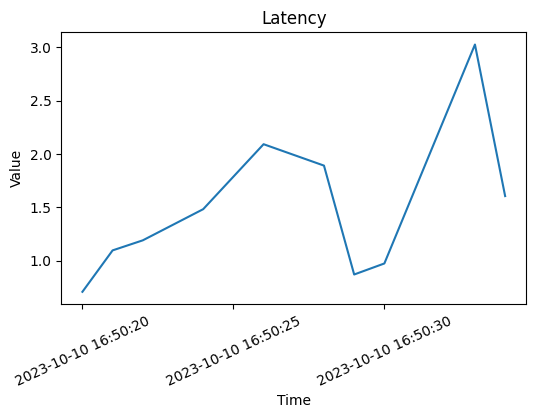

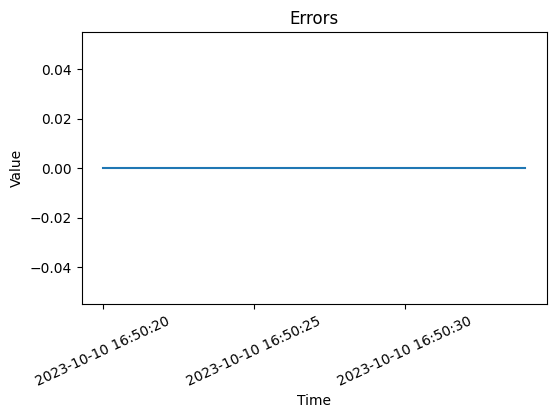

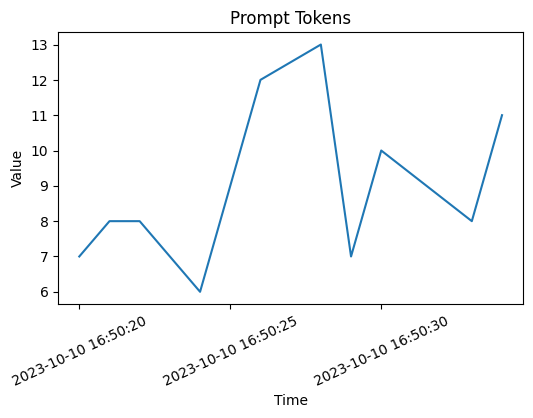

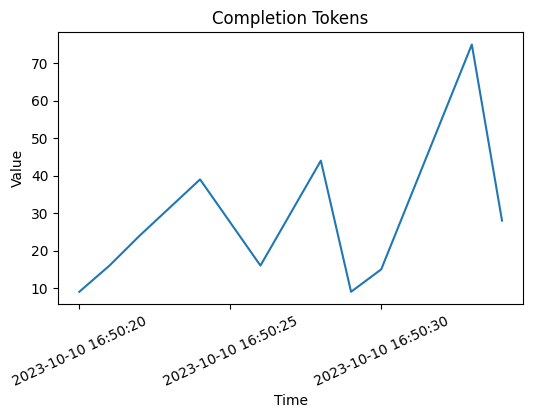

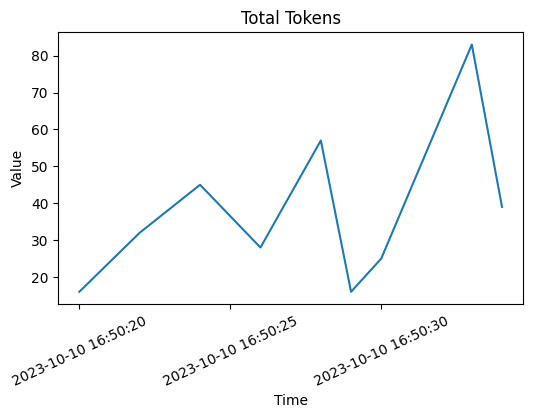

In [28]:
response = client.search_ts("__name__", "latency", 0, int(time.time()))
plot(response.text, "Latency")

response = client.search_ts("__name__", "error", 0, int(time.time()))
plot(response.text, "Errors")

response = client.search_ts("__name__", "prompt_tokens", 0, int(time.time()))
plot(response.text, "Prompt Tokens")

response = client.search_ts("__name__", "completion_tokens", 0, int(time.time()))
plot(response.text, "Completion Tokens")

response = client.search_ts("__name__", "total_tokens", 0, int(time.time()))
plot(response.text, "Total Tokens")

## Full text query on prompt or prompt outputs.

In [29]:
# Search for a particular prompt text.
query = "normandy"
response = client.search_log(query, 0, int(time.time()))
print("Results for", query, ":", response.text)

print("===")

query = "king charles III"
response = client.search_log("king charles III", 0, int(time.time()))
print("Results for", query, ":", response.text)

Results for normandy : [{"time":1696936828,"fields":{"prompt_response":"\n\nThe Normans, a people from northern France, gave their name to Normandy in the 1000s and 1100s. The Normans were descendants of Vikings who had settled in the region in the late 800s."},"text":"\n\nThe Normans, a people from northern France, gave their name to Normandy in the 1000s and 1100s. The Normans were descendants of Vikings who had settled in the region in the late 800s."},{"time":1696936826,"fields":{"prompt":"Who gave their name to Normandy in the 1000's and 1100's"},"text":"Who gave their name to Normandy in the 1000's and 1100's"},{"time":1696936821,"fields":{"prompt_response":"\n\nThe Normans first settled in Normandy in the early 10th century."},"text":"\n\nThe Normans first settled in Normandy in the early 10th century."},{"time":1696936820,"fields":{"prompt_response":"\n\nNormandy is located in France."},"text":"\n\nNormandy is located in France."},{"time":1696936819,"fields":{"prompt":"In what 

# Example 2: Summarize a piece of text using ChatOpenAI

In [30]:
# Set your key here.
# os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import WebBaseLoader
from langchain.chains.summarize import load_summarize_chain

# Create callback handler. This logs latency, errors, token usage, prompts, as well as prompt responses to Infino.
handler = InfinoCallbackHandler(
    model_id="test_chatopenai", model_version="0.1", verbose=False
)

urls = ["https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://medium.com/lyft-engineering/lyftlearn-ml-model-training-infrastructure-built-on-kubernetes-aef8218842bb",
        "https://blog.langchain.dev/week-of-10-2-langchain-release-notes/"]

for url in urls:
    loader = WebBaseLoader(url)
    docs = loader.load()

    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k", callbacks=[handler])
    chain = load_summarize_chain(llm, chain_type="stuff", verbose=False)

    chain.run(docs)

## Create Metric Charts

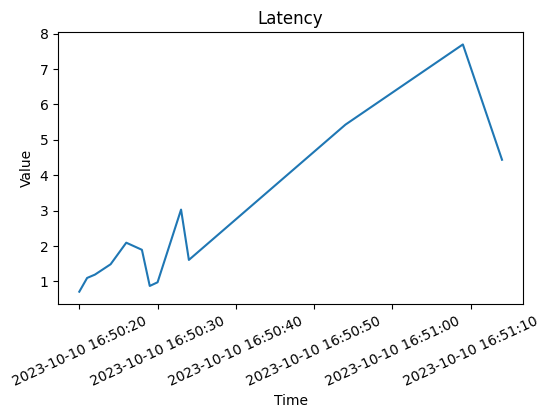

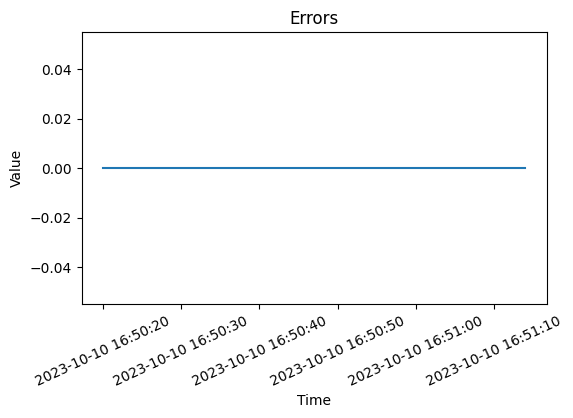

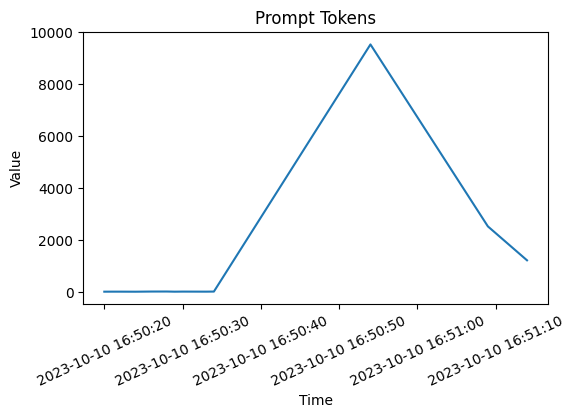

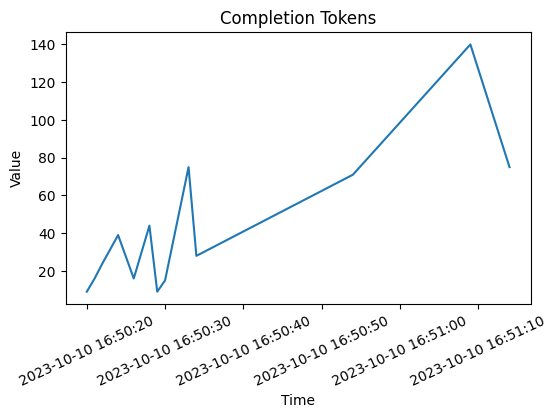

In [31]:
response = client.search_ts("__name__", "latency", 0, int(time.time()))
plot(response.text, "Latency")

response = client.search_ts("__name__", "error", 0, int(time.time()))
plot(response.text, "Errors")

response = client.search_ts("__name__", "prompt_tokens", 0, int(time.time()))
plot(response.text, "Prompt Tokens")

response = client.search_ts("__name__", "completion_tokens", 0, int(time.time()))
plot(response.text, "Completion Tokens")


In [32]:
## Full text query on prompt or prompt outputs

In [33]:
# Search for a particular prompt text.
query = "machine learning"
response = client.search_log(query, 0, int(time.time()))

# The output can be verbose - uncomment below if it needs to be printed.
# print("Results for", query, ":", response.text)

print("===")

===


In [34]:
## Stop Infino server

In [35]:
!docker rm -f infino-example

infino-example
